## Going Deeper #8 : seq2seq 번역
---
+  [Step 1. 데이터 다운로드](#step_1)
+  [Step 2. 데이터 정제](#step_2)
+  [Step 3. 데이터 토큰화](#step_3)
+  [Step 4. 모델 설계](#step_4)
+  [Step 5. 훈련하기](#step_5)
+  [생각해본 점](#pensamientos)
  +  [개선 시도](#intento_1)
+  [마무리](#conc)
---

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.2.0


---
<a id = 'step_1'></a>
### Step 1. 데이터 다운로드

> [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)    
> 이 곳에서 korean-english-park.train.tar.gz 를 다운받아 사용한다.

In [3]:
data_path = os.getenv('HOME')+'/aiffel/s2s_translation/project_data'
train_path_ko = data_path+'/korean-english-park.train.ko'
train_path_en = data_path+'/korean-english-park.train.en'
print(train_path_ko)

/home/ssac7/aiffel/s2s_translation/project_data/korean-english-park.train.ko


In [4]:
with open(train_path_ko, "r") as f:
    raw_ko = f.read().splitlines()

print("Data Size:", len(raw_ko))
print("Example:")

ind = 0
for sen in raw_ko[0:20:1]: 
    ind += 1
    print(f'{ind} >> {sen}')

Data Size: 94123
Example:
1 >> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
2 >> 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
3 >> 그러나 이것은 또한 책상도 필요로 하지 않는다.
4 >> 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
5 >> 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
6 >> 이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가들은 테러 조직이 여전히 세계 경제에 타격을 입히려 한다고 경고하고 있으며, 동남 아시아에 있는 세계 경제의 주요 통로가 위험에 처해 있다고 그들은 생각하고 있다.
7 >> 국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.
8 >> 이 보고서에따르면, "특히, 군사 작전에서 생사가 걸린 상황이 될 수도 있는 반응 속도와 시각 및 청각의 경계 상태를 유지시키기 위해 카페인이 사용될 수도 있다." 고 한다.
9 >> "결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다."
10 >> 연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 연구하고 있다고 Archibald는 말했다.
11 >> 약 200600밀리그램의, 비슷한 분량의 카페인은 또한 육체적 지구력을 강화시키는 데 효과적인 것 같으며, 특히 고도가 높은 곳에서 약해진 

In [5]:
with open(train_path_en, "r") as f:
    raw_en = f.read().splitlines()

print("Data Size:", len(raw_en))
print("Example:")

ind = 0
for sen in raw_en[0:20:1]: 
    ind += 1
    print(f'{ind} >> {sen}')

Data Size: 94123
Example:
1 >> Much of personal computing is about "can you top this?"
2 >> so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.
3 >> Like all optical mice, But it also doesn't need a desk.
4 >> uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.
5 >> Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.
6 >> After learning of several foiled al Qaeda attempts on U.S. and commercial ships in the area, experts are warning that the terror network still wants to cripple the global economy, the world's economic jugular vein in Southeast Asia is at risk.
7 >> Caffeine can help increase reaction time and improve performance for military servicemen who must perform complex tasks or who

+ 길이는 동일하다. 아마 줄 별로 매칭된 데이터 셋인 모양이다.
+ 대부분 영어 문장을 한국어로 번역한 문장으로 구성되어 있는 것 같다.
  + 한국어 문장에 의역으로 대체한 부분이 좀 보이는 것 같다.
  + 원래부터 한국어 문장이었다면 한국어 9번 같은 문장은 없었을 것 같다.
  + 12번 문장은 번역하다가 문장의 뜻이 중의적으로 될 수 있게 단어 순서가 꼬여있다.
  + 13번이나 18~20은 한국어를 영어로 바꾼 것 같다.
+ 일부 문장을 보면 기사를 번역한 데이터 셋인것 같은데 모든 문장에 적절한 번역이 연결된 데이터 셋인지는 잘 모르겠다.
  + 5번을 보면 한국어 문장에 영어 문장 에서는 언급되지 않은 말라카 해협이 나와 있다. 아마 영어 기사에서는 앞에서 언급했던 내용을 다르게 언급한 표현을 한국어 문장에서는 고유 명사로 살린 것 같다.
  + 6번도 5번과 유사한데 괄호로 영어에서 아마 앞에서 언급한 terror를 대체하는 다른 표현을 사용하며 생략한 terror 라는 단어를 괄호로 살려주고 있다.
  + 4번은 영어 문장에서 언급하지 않은 가격 정보를 언급하고 있다.
  + 2번은 연결이 아예 잘못 된 것 같다.
  + 18, 19번 문장은 영어 문장 앞부분이 잘려나간 것 같다.
  + 16번도 번역이 잘 된 것인지는 의문이다.
  + 그 밖에서 13번 같은 예도 있다.
+ 특수 기호 처리가 애매할 수도 있을 것 같다.
  + 아마 데이터 셋에는 없는 원래 기사 문장에 있었을 앞의 부분을 이어가는 표현을 한국어 에서는 그대로 살려오면서 (괄호) 형식으로 표현하는 데 이러한 데이터가 많다면 괄호 처리를 별도로 해줘야 하지 않을까 고민이 필요할 것 같다. 13번 문장과 같이 영문과 국문에서 괄호를 동일한 용법으로 사용하는 데이터도 있으니 지금 단계에서는 건드리지 않기로 한다.
  + 11번 문장은 영어 문장에서는 200-600mg 으로 표현된 내용이 한국어문장에서는 200600밀리그램으로 정리 되어 있다. 처음 전처리 하면서 특수기호를 삭제하고 붙여버린게 아닐까 싶다. 한국어 문장에서는 보통 물결표를 많이 쓰니까 물결표가 삭제되고 붙은게 아닐까?

---
<a id = 'step_2'> </a>
### Step 2. 데이터 정제

In [6]:
type(raw_ko), type(raw_en)

(list, list)

In [7]:
len(raw_ko) == len(set(raw_ko)), len(raw_en) == len(set(raw_en))

(False, False)

+ 중복 데이터가 있다.

In [8]:
len(set(raw_ko)), len(set(raw_en))

(77591, 75598)

+ 한국어 문장과 영어 문장의 중복 수가 다르다.

In [9]:
import pandas as pd
raw_df = pd.DataFrame( {
    'kor' : raw_ko,
    'eng' : raw_en
})
raw_df.head(3)

,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."


In [10]:
raw_df.duplicated().sum()

15155

In [11]:
len(raw_ko) - len(set(raw_ko)), len(raw_en) - len(set(raw_en))

(16532, 18525)

In [12]:
raw_df.duplicated(['kor']).sum(), raw_df.duplicated(['eng']).sum()

(16532, 18525)

+ 한국어 문장 각기, 영어 문장 각기 중복되는 수와 영어 문장과 한국어 문장이 동시에 중복되는 수가 다른 것 같다. 
  + 둘 다 중복되는 경우만 제거하기로 한다. 

In [13]:
cond = raw_df.duplicated()
raw_df[cond][:100:20]

,kor,eng
7789,이들 의원 중 1명은 빌 클린턴 전 대통령이 지난 몇 주간 부인 힐러리에게 오바마의...,"One of the lawmakers said Clinton's husband, f..."
16551,매케인은 지지자들에게 “오늘 경선에서 승리해 기쁘며 또한 여러분에게 고마움을 표하고...,"""I am very, very grateful and pleased to note ..."
24494,‘키스의 기술(원제: The Art of Kissing )의 저자 마이클 크리스찬(...,"Michael Christian, author of ""The Art of Kissi..."
36281,"그는 이어 ""25일 저녁 6시 30분까지 탈레반 수감자들이 석방되지 않으면 인질 일...","If by two o'clock today (0930 GMT), the Taliba..."
49236,"SEOUL, South Korea (AP)/송완영 (JOINS)",ÏÀ» Á¦°øÇÏÁö ¾Ê½À´Ï´Ù.


+ 인덱스 49236을 통해 한국어 문장을 영어로 바꾼 데이터도 있다는 것을 확인하였다.

In [14]:
print(len(raw_df))
raw_df.drop_duplicates(inplace=True)
print(len(raw_df))

94123
78968


In [15]:
94123 - 78968

15155

In [16]:
from konlpy.tag import Mecab

mecab = Mecab()

def preprocess_kor(sentence):
    sentence = sentence.strip()
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)    # ?.!, 가 나오면 앞에 한칸 띄어주기
    sentence = re.sub(r'[" "]+', " ", sentence)    # 띄어쓰기 여러개가 되어 있으면 하나로 줄이기
    sentence = re.sub(r"[^ㄱ-ㅎ|가-힣?.!,]+", " ", sentence).strip()    # 한글 ?.!, 문자 부호가 아니면 빈칸으로 대체
    sentence = mecab.morphs(sentence)    # mecab() 이용해 문장 분절
    
    return sentence

In [17]:
def preprocess_eng(sentence):
    sentence = sentence.strip()
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)    # ?.!, 가 나오면 앞에 한칸 띄어주기
    sentence = re.sub(r'[" "]+', " ", sentence)    # 띄어쓰기 여러개가 되어 있으면 하나로 줄이기
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence).strip()    # 알파벳 ?.!, 문자부호가 아니면 빈칸으로 대체
    
    sentence = '<start> ' + sentence    # '<start> ' 뒤에 sentence 붙이기
    sentence += ' <end>'    # sentence 뒤에 ' <end>' 붙이기
    sentence = sentence.split()    # 띄어쓰기 기준으로 문장 나누기
    
    return sentence

In [18]:
raw_df['cleaned_ko'] = raw_df['kor'].map(preprocess_kor)
raw_df['cleaned_en'] = raw_df['eng'].map(preprocess_eng)

In [19]:
raw_df.iloc[0,2]

['개인',
 '용',
 '컴퓨터',
 '사용',
 '의',
 '상당',
 '부분',
 '은',
 '이것',
 '보다',
 '뛰어날',
 '수',
 '있',
 '느냐',
 '?']

In [20]:
raw_df.iloc[0,3]

['<start>',
 'Much',
 'of',
 'personal',
 'computing',
 'is',
 'about',
 'can',
 'you',
 'top',
 'this',
 '?',
 '<end>']

In [21]:
# 40 이하 길이인 데이터만 남기기
cleaned_corpus_df = raw_df[raw_df['cleaned_ko'].map(lambda x: len(x) < 41) & raw_df['cleaned_en'].map(lambda x: len(x) < 41)].iloc[:,2:4]
cleaned_corpus_df

,cleaned_ko,cleaned_en
0,"[개인, 용, 컴퓨터, 사용, 의, 상당, 부분, 은, 이것, 보다, 뛰어날, 수,...","[<start>, Much, of, personal, computing, is, a..."
1,"[모든, 광, 마우스, 와, 마찬가지, 로, 이, 광, 마우스, 도, 책상, 위, ...","[<start>, so, a, mention, a, few, weeks, ago, ..."
2,"[그러나, 이것, 은, 또한, 책상, 도, 필요, 로, 하, 지, 않, 는다, .]","[<start>, Like, all, optical, mice, ,, But, it..."
8,"[결정, 적, 인, 순간, 에, 그, 들, 의, 능력, 을, 증가, 시켜, 줄, 그...","[<start>, Something, that, will, boost, their,..."
9,"[연구가, 들, 이, 이미, 커피, 대체, 품, 으로서, 음식, 대용, 과자, 나,...","[<start>, Researchers, are, already, exploring..."
...,...,...
94118,"[우리, 는, 월, 일, 김승연, 회장, 과, 그, 의, 아들, 이, 보복, 폭행,...","[<start>, We, are, hoping, to, seize, material..."
94119,"[월요일, 술집, 종업원, 명, 은, 김, 회장, 과, 아들, 에게, 폭행, 을, ...","[<start>, On, Monday, ,, police, secured, stat..."
94120,"[그러나, 불, 충분, 한, 증거, 확보, 로, 수사, 에, 어려움, 이, 있, 다...","[<start>, But, the, lack, of, material, eviden..."
94121,"[김, 회장, 과, 그, 의, 아들, 은, 보복, 폭행, 혐의, 를, 강력히, 부인...","[<start>, Kim, and, his, son, both, deny, the,..."


+ 한국어, 영어 모두 길이 40개 이하의 문장들만 남겨서 63139의 문장 묶음이 남았다.

---
<a id = 'step_3'> </a>
### Step 3. 데이터 토큰화

In [22]:
# 리스트로 옮기기
corpus_ko = list(cleaned_corpus_df['cleaned_ko'])
corpus_en = list(cleaned_corpus_df['cleaned_en'])
print(f'한국어 문장 : {corpus_ko[0]}')
print(f'영어 문장 : {corpus_en[0]}')

한국어 문장 : ['개인', '용', '컴퓨터', '사용', '의', '상당', '부분', '은', '이것', '보다', '뛰어날', '수', '있', '느냐', '?']
영어 문장 : ['<start>', 'Much', 'of', 'personal', 'computing', 'is', 'about', 'can', 'you', 'top', 'this', '?', '<end>']


In [23]:
# 데이터 지우기
del raw_df
del cleaned_corpus_df 

In [24]:
# 정제된 텍스트를 아래 tokenize() 함수를 사용해 토큰화하고 텐서로 변환
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [25]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(corpus_ko)
dec_tensor, dec_tokenizer = tokenize(corpus_en)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 37077
English Vocab Size: 38540


---
<a id = 'step_4'> </a>
### Step 4. 모델 설계

In [27]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [28]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [29]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [30]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 512
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 512)
Decoder Output: (64, 38541)
Decoder Hidden State: (64, 512)
Attention: (64, 40, 1)


In [31]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # math.equal ; real 값을 0과 비교해 같으면 True, 다르면 False. math.logical_not ; bool값의 부정 True면 False, False면 True  
    loss = loss_object(real, pred)    # 타겟과 예측값 간의 로스 계산
    
    mask = tf.cast(mask, dtype=loss.dtype)    # bool 값을 loss 데이터 형태와 같게 변환 False는 0.으로 변화할 듯.
    loss *= mask    # real 값이 0이면 mask 값이 False가 되고 cast에서 0이 되어 위에서 계산한 loss와 0을 곱해 최종 loss를 0으로 바꾼다. 아니면 1을 곱해 그대로 반환할 듯.
    
    return tf.reduce_mean(loss)    # 차원 축소하여 계산한 평균값

In [32]:
@tf.function    # 학습 외의 텐서플로우 계산을 gpu에서 할 수 있게 표시해 둔다.
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:    # 모든 계산 값을 저장해 둔다.
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

---
<a id = 'step_5'></a>
### Step 5. 훈련하기

In [36]:
from tqdm import tqdm    # tqdm
import random


EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 987/987 [06:20<00:00,  2.59it/s, Loss 3.9975]


In [89]:
mecab = Mecab()

def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎ|가-힣?.!,]+", " ", sentence)
    sentence = mecab.morphs(sentence)

    return sentence
    

def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))


> ## 예문 ##
K1) 오바마는 대통령이다.   
K2) 시민들은 도시 속에 산다.   
K3) 커피는 필요 없다.   
K4) 일곱 명의 사망자가 발생했다.   

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/home/ssac7/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssac7/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator


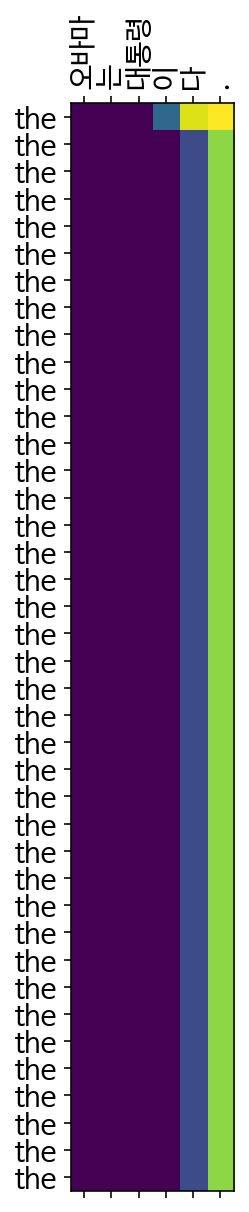

In [90]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/home/ssac7/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssac7/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


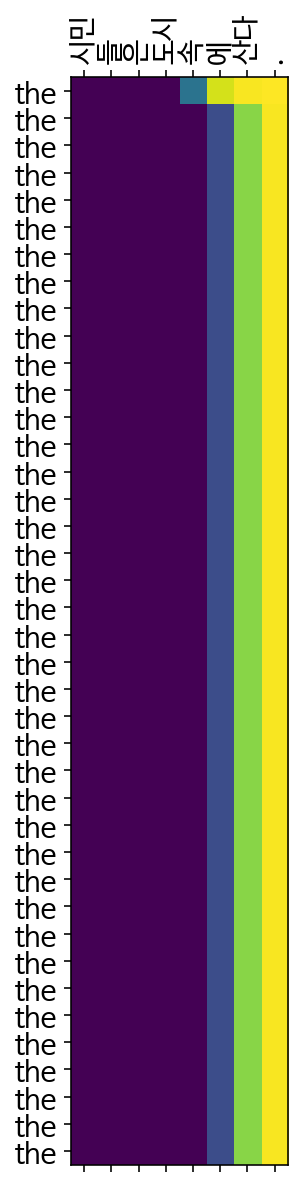

In [61]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/home/ssac7/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssac7/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


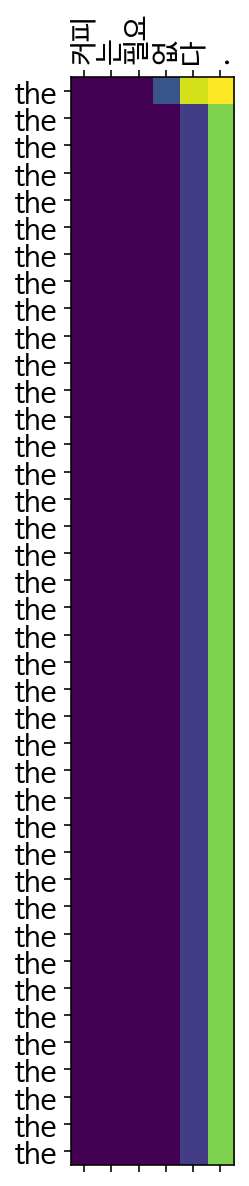

In [62]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/home/ssac7/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssac7/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


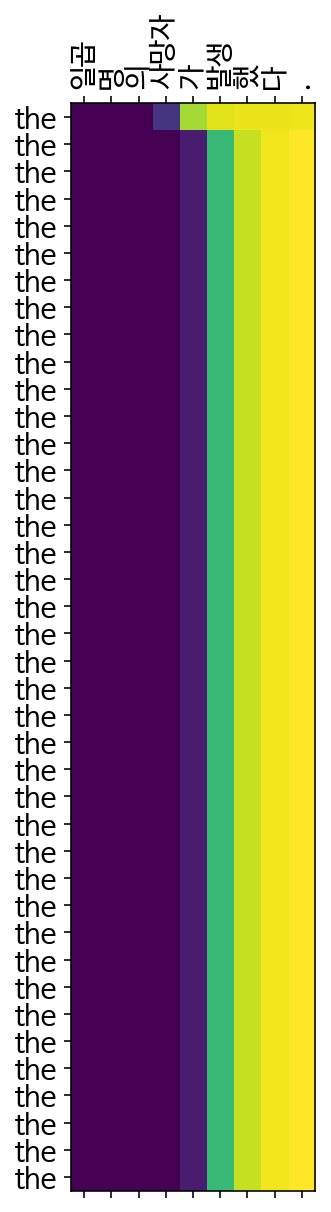

In [63]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)c

---
<a id = 'pensamientos'></a>

### 생각해본 점
+ loss가 잘 감소하지 않는다.
  + 초반에도 loss감소가 잘 이루어 지지 않는 것을 보면 언더피팅인 것 같다. 데이터를 추가로 수집할 수 없으므로 모델의 크기를 줄여보자
    + 임베딩 벡터의 차원을 줄이고 학습 unit의 수도 줄여보자.
      + 학습도 좀 더 오래 시켜보자.
    + 학습해야 하는 단어의 종류를 줄여보자.
   

---
<a id = 'intento_1'></a>

#### 개선 시도. 모델 크기를 줄이고, 좀 더 오래 학습시키기

In [83]:
BATCH_SIZE     = 128
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 128
embedding_dim = 64

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

In [84]:
@tf.function    # 학습 외의 텐서플로우 계산을 gpu에서 할 수 있게 표시해 둔다.
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:    # 모든 계산 값을 저장해 둔다.
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [85]:
from tqdm import tqdm    # tqdm
import random


EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 30: 100%|██████████| 494/494 [01:18<00:00,  6.26it/s, Loss 2.1712]


/home/ssac7/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssac7/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator


Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is the democratic presidential nomination . <end> 


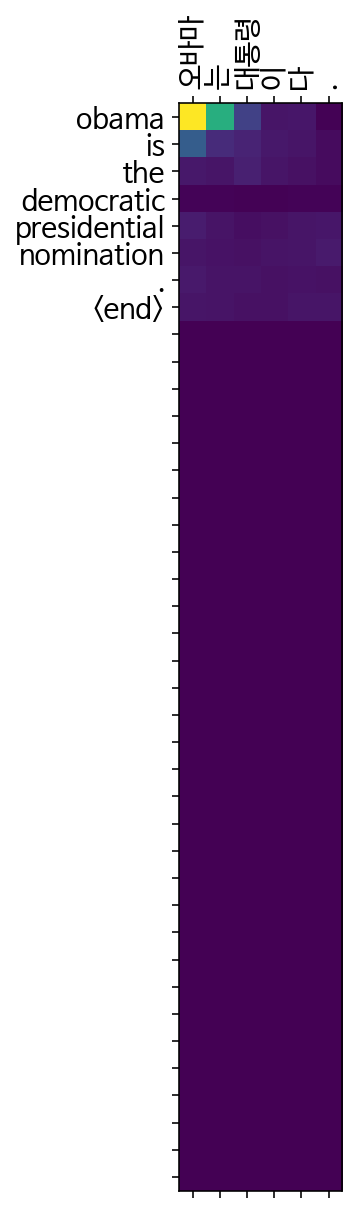

In [86]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: the number of the victims are still being held to the area . <end> 


/home/ssac7/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssac7/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator


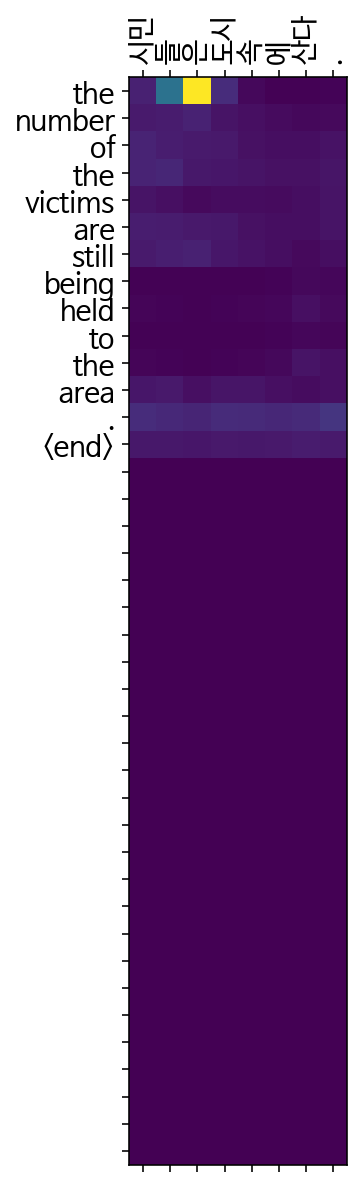

In [87]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the ap s . . <end> 


/home/ssac7/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssac7/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator


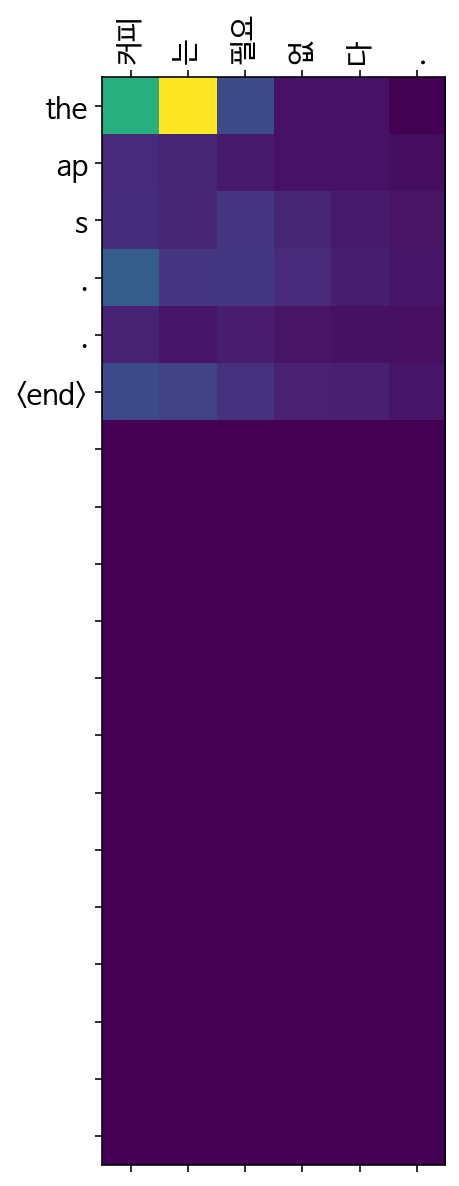

In [88]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the quake was killed in the capital , killing at least people were killed in the capital , killing at least people were killed in the capital , killing at least people were killed in the capital , killing at 


/home/ssac7/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ssac7/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator


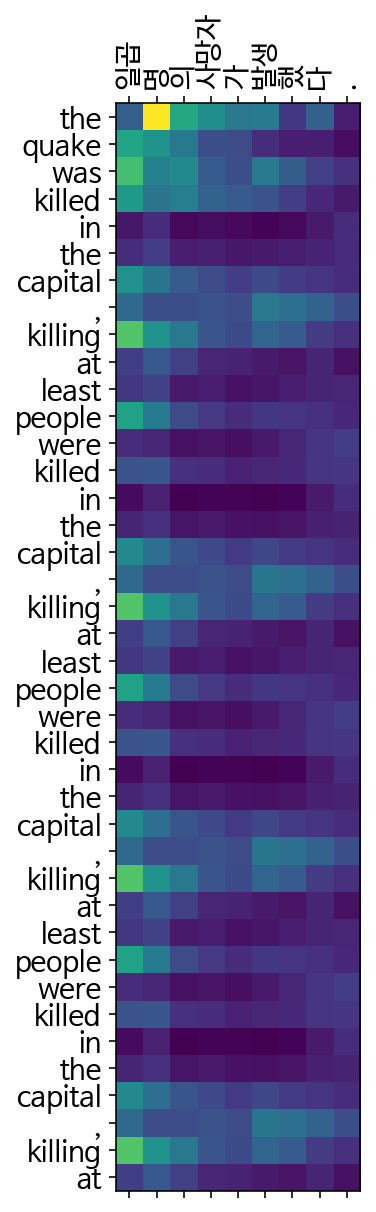

In [89]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

+ 예문 1. 오바마는 대통령이다. 의 경우엔 그나마 적절하게 문장이 구성된 것 같으나 나머지 예문의 결과물이 좋지 못하다.
+ loss는 지속적으로 감소하고 있었으므로 좀 더 학습을 시킨다면 더 좋은 결과물이 나올 수 있을 것 같다.

---
<a id = 'conc'></a>
#### 마무리 : 단어 수 줄이고 학습해 보기 시도 : 실패

In [116]:
vocab_size = 15000

def tokenize(corpus, vocab_size):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words = vocab_size, oov_token= '<unk>')
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

enc_tensor, enc_tokenizer = tokenize(corpus_ko, 15000)
dec_tensor, dec_tokenizer = tokenize(corpus_en, 15000+2) # start, end 토큰이 붙어 있으므로 2개를 추가해 준다.

In [150]:
def check_enc_corpus(idx):
    result = ''
    for i in enc_tensor[idx]:
        if i == 0 :
            print(result)
            break
        result += enc_tokenizer.index_word[i] + ' '

In [154]:
check_enc_corpus(100)

미국 의 빌 클린턴 대통령 은 년 하노이 외곽 에서 격추 된 의 추락 장소 를 방문 한 후 에 베트남 의 <unk> 시 에 도착 했 다 . 


In [152]:
def check_dec_corpus(idx):
    result = ''
    for i in dec_tensor[idx]:
        if i == 0 :
            print(result)
            break
        result += dec_tokenizer.index_word[i] + ' '

In [155]:
check_dec_corpus(100)

<start> thousands of vietnamese lined the president s route from tan son <unk> airport to his hotel , many waving and cheering in stark contrast to clinton s earlier visit to the site where air force capt . <end> 


In [185]:
from tqdm import tqdm    # tqdm
import random


EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 30: 100%|██████████| 247/247 [01:02<00:00,  3.98it/s, Loss 3.6868]


+ 단어 수를 줄이고 학습해 봤지만 잘 학습되지 않았다.
  + 모델 크기를 더 줄여봐도 더 늘여봐도 잘 학습이 되지 않았다.
+ 잘 학습되지 않은 경우 번역 결과물은 다 the 였다.
  + tokenizer.index_word 를 살펴 보면 the가 제일 빈도수가 높아 제일 앞 인덱스를 갖는다. 단순히 빈도수 높은 단어만 내놓개 되는 모양이다.
  + 다른 사람들은 어떻게 잘 학습시켰는지 궁금하다. 